# Automating Validation of Data Quality
## Author: David Schanzer
## Student ID: 82329622
### Subject: 32933 Research Project
### Session: Spring 2023
### Assessment 1: Prototype Research
### Supervisor: Dr Amara Atif

Import all required Python modules

In [3]:
import warnings
warnings.filterwarnings('ignore')

from abc import abstractmethod
from collections import namedtuple, Counter as count
import copy
from datetime import datetime
from enum import IntEnum
from hyperloglog import HyperLogLog
import os
from math import log10, floor
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from nltk.util import ngrams
import numpy as np
import pandas as pd
from pathlib import Path
import pytz
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score
import time
from tqdm.notebook import trange

# Select which Novelty Detection model is imported - uncomment and comment accordingly
from pyod.models import knn
#from pyod.models import ecod
#from pyod.models import iforest
#from pyod.models import ocsvm
#from pyod.models import vae

**_round_to_n:_** Define a method to round a decimal to n significant digits.

In [4]:
def round_to_n(x, n):
    if x == 0:
        value = 0
    else:
        value = round(x, -int(floor(log10(abs(x)))) + (n - 1))
        
    return value

**_float_converter:_** Define a method to convert a number to a float, or return NaN if not convertible.

In [5]:
def float_converter(num):
    try:
        return np.float(num)
    except:
        return np.nan

**_rmtree:_** Define a method to recursively remove all files and folders below the nominated path.

In [6]:
def rmtree(f: Path):
    if f.is_file():
        f.unlink()
    else:
        for child in f.iterdir():
            rmtree(child)
        f.rmdir()

**_create_folder:_** Define a method to create a new empty folder at the nominated path, removing any existing folder of the same name.

In [7]:
def create_folder(folderPath):
    folderPathObj = Path(folderPath)
    # If folder already exists
    if folderPathObj.exists():
        # then recursively delete all files and folders
        rmtree(folderPathObj)

    # Sleep for 1 second to allow the file system to register the folder deletion
    time.sleep(1)
    
    # Create a new empty folder
    folderPathObj.mkdir()

**_Quality:_** Define an enumerator class to distinguish good files from bad files.

In [8]:
class Quality(IntEnum):
    GOOD = 0
    BAD = 1

**_Learner:_** Define a class of abstract methods that can be used by any specific subsequent Novelty Detection algorithm.

In [9]:
class Learner:
    @abstractmethod
    def fit(history):
        pass

    @abstractmethod
    def predict(X):
        pass
    
    @abstractmethod
    def predict_proba(X):
        pass
    
    @abstractmethod
    def decision_function(X):
        pass

**_Novelty Detection algorithm 1:_** Define the class for the kNN algorithm, containing fit, predict and predict_proba methods.

In [10]:
class KNNLearner(Learner):
    def __init__(self):
        # https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn
        self.classifier = None

    def fit(self, history, contamination):
        learner = knn.KNN(contamination = contamination,
                      n_neighbors = 7,
                      method = 'mean',
                      metric = 'euclidean',
                      algorithm = 'ball_tree')

        # Convert list to dataframe temporarily
        df_history = pd.DataFrame(history)

        # Replace any NaN values with the mean for that column
        df_history.fillna(df_history.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_history.mean() itself returns NaN)
        df_history.fillna(0, inplace=True)

        # Convert dataframe back to list
        history = df_history.values.tolist()                 
        
        self.classifier = Pipeline([
            ('scaler', MinMaxScaler()),
            ('learner', learner)
        ]).fit(history)

        # get the prediction labels and outlier scores of the training data -  binary labels
        # (0: inliers, 1: outliers)
        y_all_predictions = learner.labels_      

        # get raw outlier scores
        y_all_scores = learner.decision_scores_  
        
        # get threshold score
        threshold = learner.threshold_

        return threshold

    def predict(self, X_test):
        assert self.classifier is not None, '.fit first'

        # Convert list to dataframe temporarily
        df_X_test = pd.DataFrame(X_test)

        # Replace any NaN values with the mean for that column
        df_X_test.fillna(df_X_test.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_X_test.mean() itself returns NaN)
        df_X_test.fillna(0, inplace=True)

        # Convert dataframe back to list
        X_test = df_X_test.values.tolist()                 
        
        # get the prediction on the test data - outlier labels (0=not outlier or 1=outlier)
        y_test_pred = self.classifier.predict(X_test)
        
        # get outlier scores
        y_test_scores = self.classifier.decision_function(X_test)  
        
        return y_test_pred, y_test_scores
    
    def predict_proba(self, X):
        assert self.classifier is not None, '.fit first'
            
        outlier_probability = self.classifier.predict_proba(X, method='linear', return_confidence=False)
        return outlier_probability

**_Novelty Detection algorithm 2:_** Define the class for the ECOD algorithm, containing fit, predict and predict_proba methods.

In [11]:
class ECODLearner(Learner):
    def __init__(self):
        # https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.ecod
        self.classifier = None

    def fit(self, history, contamination):
        learner = ecod.ECOD(contamination = contamination)

        # Convert list to dataframe temporarily
        df_history = pd.DataFrame(history)

        # Replace any NaN values with the mean for that column
        df_history.fillna(df_history.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_history.mean() itself returns NaN)
        df_history.fillna(0, inplace=True)

        # Convert dataframe back to list
        history = df_history.values.tolist()                 
        
        self.classifier = Pipeline([
            ('scaler', MinMaxScaler()),
            ('learner', learner)
        ]).fit(history)

        # get the prediction labels and outlier scores of the training data -  binary labels
        # (0: inliers, 1: outliers)
        y_all_predictions = learner.labels_      

        # get raw outlier scores
        y_all_scores = learner.decision_scores_  
        
        # get threshold score
        threshold = learner.threshold_

        return threshold

    def predict(self, X_test):
        assert self.classifier is not None, '.fit first'

        # Convert list to dataframe temporarily
        df_X_test = pd.DataFrame(X_test)

        # Replace any NaN values with the mean for that column
        df_X_test.fillna(df_X_test.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_X_test.mean() itself returns NaN)
        df_X_test.fillna(0, inplace=True)

        # Convert dataframe back to list
        X_test = df_X_test.values.tolist()                 
        
        # get the prediction on the test data - outlier labels (0=not outlier or 1=outlier)
        y_test_pred = self.classifier.predict(X_test)
        
        # get outlier scores
        y_test_scores = self.classifier.decision_function(X_test)  
        
        return y_test_pred, y_test_scores
    
    def predict_proba(self, X):
        assert self.classifier is not None, '.fit first'
            
        outlier_probability = self.classifier.predict_proba(X, method='linear', return_confidence=False)
        return outlier_probability

**_Novelty Detection algorithm 3:_** Define the class for the IsolationForest algorithm, containing fit, predict and predict_proba methods.

In [12]:
class IsolationForestLearner(Learner):
    def __init__(self):
        # https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest
        self.classifier = None

    def fit(self, history, contamination):
        learner = iforest.IForest(contamination = contamination)

        # Convert list to dataframe temporarily
        df_history = pd.DataFrame(history)

        # Replace any NaN values with the mean for that column
        df_history.fillna(df_history.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_history.mean() itself returns NaN)
        df_history.fillna(0, inplace=True)

        # Convert dataframe back to list
        history = df_history.values.tolist()                 
        
        self.classifier = Pipeline([
            ('scaler', MinMaxScaler()),
            ('learner', learner)
        ]).fit(history)

        # get the prediction labels and outlier scores of the training data -  binary labels
        # (0: inliers, 1: outliers)
        y_all_predictions = learner.labels_      

        # get raw outlier scores
        y_all_scores = learner.decision_scores_  
        
        # get threshold score
        threshold = learner.threshold_

        return threshold

    def predict(self, X_test):
        assert self.classifier is not None, '.fit first'

        # Convert list to dataframe temporarily
        df_X_test = pd.DataFrame(X_test)

        # Replace any NaN values with the mean for that column
        df_X_test.fillna(df_X_test.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_X_test.mean() itself returns NaN)
        df_X_test.fillna(0, inplace=True)

        # Convert dataframe back to list
        X_test = df_X_test.values.tolist()                 
        
        # get the prediction on the test data - outlier labels (0=not outlier or 1=outlier)
        y_test_pred = self.classifier.predict(X_test)
        
        # get outlier scores
        y_test_scores = self.classifier.decision_function(X_test)  
        
        return y_test_pred, y_test_scores
    
    def predict_proba(self, X):
        assert self.classifier is not None, '.fit first'
            
        outlier_probability = self.classifier.predict_proba(X, method='linear', return_confidence=False)
        return outlier_probability

**_Novelty Detection algorithm 4:_** Define the class for the OCSVM algorithm, containing fit, predict and predict_proba methods.

In [13]:
class OCSVMLearner(Learner):
    def __init__(self):
        # https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.ocsvm
        self.classifier = None

    def fit(self, history, contamination):
        learner = ocsvm.OCSVM(contamination = contamination)

        # Convert list to dataframe temporarily
        df_history = pd.DataFrame(history)

        # Replace any NaN values with the mean for that column
        df_history.fillna(df_history.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_history.mean() itself returns NaN)
        df_history.fillna(0, inplace=True)

        # Convert dataframe back to list
        history = df_history.values.tolist()                 
        
        self.classifier = Pipeline([
            ('scaler', MinMaxScaler()),
            ('learner', learner)
        ]).fit(history)

        # get the prediction labels and outlier scores of the training data -  binary labels
        # (0: inliers, 1: outliers)
        y_all_predictions = learner.labels_      

        # get raw outlier scores
        y_all_scores = learner.decision_scores_  
        
        # get threshold score
        threshold = learner.threshold_

        return threshold

    def predict(self, X_test):
        assert self.classifier is not None, '.fit first'

        # Convert list to dataframe temporarily
        df_X_test = pd.DataFrame(X_test)

        # Replace any NaN values with the mean for that column
        df_X_test.fillna(df_X_test.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_X_test.mean() itself returns NaN)
        df_X_test.fillna(0, inplace=True)

        # Convert dataframe back to list
        X_test = df_X_test.values.tolist()                 
        
        # get the prediction on the test data - outlier labels (0=not outlier or 1=outlier)
        y_test_pred = self.classifier.predict(X_test)
        
        # get outlier scores
        y_test_scores = self.classifier.decision_function(X_test)  
        
        return y_test_pred, y_test_scores
    
    def predict_proba(self, X):
        assert self.classifier is not None, '.fit first'
            
        outlier_probability = self.classifier.predict_proba(X, method='linear', return_confidence=False)
        return outlier_probability

**_Novelty Detection algorithm 5:_** Define the class for the VAE algorithm, containing fit, predict and predict_proba methods.

In [14]:
class VAELearner(Learner):
    def __init__(self):
        # https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.vae
        self.classifier = None

    def fit(self, history, contamination):
        learner = vae.VAE(contamination = contamination)

        # Convert list to dataframe temporarily
        df_history = pd.DataFrame(history)

        # Replace any NaN values with the mean for that column
        df_history.fillna(df_history.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_history.mean() itself returns NaN)
        df_history.fillna(0, inplace=True)

        # Convert dataframe back to list
        history = df_history.values.tolist()                 
        
        self.classifier = Pipeline([
            ('scaler', MinMaxScaler()),
            ('learner', learner)
        ]).fit(history)

        # get the prediction labels and outlier scores of the training data -  binary labels
        # (0: inliers, 1: outliers)
        y_all_predictions = learner.labels_      

        # get raw outlier scores
        y_all_scores = learner.decision_scores_  
        
        # get threshold score
        threshold = learner.threshold_

        return threshold

    def predict(self, X_test):
        assert self.classifier is not None, '.fit first'

        # Convert list to dataframe temporarily
        df_X_test = pd.DataFrame(X_test)

        # Replace any NaN values with the mean for that column
        df_X_test.fillna(df_X_test.mean(), inplace=True)   
        
        # Now replace any remaining NaN values with 0 (in case df_X_test.mean() itself returns NaN)
        df_X_test.fillna(0, inplace=True)

        # Convert dataframe back to list
        X_test = df_X_test.values.tolist()                 
        
        # get the prediction on the test data - outlier labels (0=not outlier or 1=outlier)
        y_test_pred = self.classifier.predict(X_test)
        
        # get outlier scores
        y_test_scores = self.classifier.decision_function(X_test)  
        
        return y_test_pred, y_test_scores
    
    def predict_proba(self, X):
        assert self.classifier is not None, '.fit first'
            
        outlier_probability = self.classifier.predict_proba(X, method='linear', return_confidence=False)
        return outlier_probability

**_DataProfiler:_** Define a class of descriptive statistics to be calculated for each file.

In [15]:
class DataProfiler:
    class __DP:
        def __init__(self):
            self.analyzer = {
                'Completeness': lambda x, dtype: self.completeness(x, dtype),
                'Uniqueness': lambda x, dtype: self.uniqueness(x, dtype),
                'ApproxCountDistinct': lambda x, dtype: self.approx_count_distinct(x, dtype),
                'ModeRatio': lambda x, dtype: self.mode_ratio(x, dtype),
                'Mean': lambda x, dtype: self.mean(x, dtype),
                'Minimum': lambda x, dtype: self.minimum(x, dtype),
                'Maximum': lambda x, dtype: self.maximum(x, dtype),
                'StandardDeviation': lambda x, dtype: self.standard_deviation(x, dtype),
                'PeculiarityIndex': lambda x, dtype: self.peculiarity(x, dtype),
            }

            self.dtype_checking = {
                'int64': True,
                'float64': True
            }

        def completeness(self, x, dtype):
            completeness = 1. - np.sum(pd.isna(x)) / x.shape[0]

            return completeness

        def uniqueness(self, x, dtype):
            tmp = [i for i in count(x).values() if i == 1]
            uniqueness = 1. * np.sum(tmp) / pd.notna(x).shape[0]
                
            return uniqueness

        #def count_distinct(self, x, dtype):
        #    return 1. * len(count(x).keys()) / pd.notna(x).shape[0]

        def approx_count_distinct(self, x, dtype):
            hll = HyperLogLog(.01)
            for idx, val in x.items():
                hll.add(str(val))
        
            approx_count_distinct = len(hll)
            
            return approx_count_distinct

        def mode_ratio(self, x, dtype):
            # Calculate the number of rows with the mode (most frequent) value as a proportion of the non-NaN rows
            mode_ratio = 1. * max(count(x).values()) / pd.notna(x).shape[0]
                
            return mode_ratio

        def mean(self, x, dtype):
            # Force calculation by excluding non-numeric cells
            mean = pd.to_numeric(x, errors='coerce').mean()   
                
            return mean

        def minimum(self, x, dtype):
            # Force calculation by excluding non-numeric cells
            min = pd.to_numeric(x, errors='coerce').min()   
                
            return min

        def maximum(self, x, dtype):
            # Force calculation by excluding non-numeric cells
            max = pd.to_numeric(x, errors='coerce').max()   
                
            return max 

        def standard_deviation(self, x, dtype):
            # Force calculation by excluding non-numeric cells
            sd = pd.to_numeric(x, errors='coerce').std()   
                
            return sd 

        def peculiarity(self, x, dtype):
            # Index of peculiarity is based on the bi- and trigram tables of a textual attribute and reflects the
            # likelihood of the hypothesis that trigrams in a given word are produced from the same data source
            # that produced the trigram table. This index is originally applied for detection of typographical
            # errors and facilitates detection of typos in text or a “peculiar” occurrence of symbols in words.
            def _peculiarity_index(word, count2grams, count3grams):
                t = []
                for xyz in ngrams(str(word), 3):
                    xy, yz = xyz[:2], xyz[1:]
                    cxy, cyz = count2grams.get(xy, 0), count2grams.get(yz, 0)
                    cxyz = count3grams.get(xyz, 0)
                    t.append(.5* (np.log(cxy) + np.log(cyz) - np.log(cxyz)))

                return np.sqrt(np.mean(np.array(t)**2))

            aggregated_string = ' '.join(map(str, x))
            c2gr = count(ngrams(aggregated_string, 2))
            c3gr = count(ngrams(aggregated_string, 3))

            peculiarityIndex = x.apply(lambda y: _peculiarity_index(y, c2gr, c3gr)).max()
                
            return peculiarityIndex

    instance = None

    def __init__(self):
        if not DataProfiler.instance:
            DataProfiler.instance = DataProfiler.__DP()

    def __getattr__(self, name):
        return getattr(self.instance, name)

    def _compute_for_column(self, column, dtype, *analyzers):
        return [self.instance.analyzer[name](column, dtype) for name in analyzers]

    def compute_for(self, batch, return_labels=False):
        profile, labels = [], []
        generic_metrics = ['Completeness', 'Uniqueness', 'ApproxCountDistinct', 'ModeRatio']
        numeric_metrics = ['Mean', 'Minimum', 'Maximum', 'StandardDeviation']
        dtypeList = []
        
        for col, dtype in zip(batch.columns, batch.dtypes):
            # For every column, compute generic metrics,
            # add additional numeric metrics for numeric columns
            metrics = copy.deepcopy(generic_metrics)
            
            if self.dtype_checking.get(str(dtype), False):
                metrics.extend(numeric_metrics)
                
            # Dummy check for likely-to-be-strings
            if dtype == 'object': 
                metrics.append('PeculiarityIndex')
                
            dtypeList.append(dtype)
            column_profile = self._compute_for_column(batch[col], dtype, *metrics)
            profile.extend(column_profile)
            labels.extend([f'{col}_{m}' for m in metrics])

        return profile if not return_labels else (profile, labels)

**_DataQualityValidator:_** Define a class to validate the file's data quality using the chosen Novelty Detection algorithm.

In [16]:
class DataQualityValidator:
    def __init__(self):
        # Here is where you select which Novelty Detection method is used - uncomment and comment accordingly
        self.clf = KNNLearner()
        #self.clf = ECODLearner()
        #self.clf = IsolationForestLearner()
        #self.clf = OCSVMLearner()
        #self.clf = VAELearner()
        self.history = []

    def add(self, batch):
        # Replace any infinite values in the batch with a very large valid float64 value
        batch = [1.0e+100 if element == np.inf else element for element in batch]

        self.history.append(batch)
        
        return self

    def test(self, batch, contamination):
        # re-fit the model from scratch
        threshold = self.clf.fit(self.history, contamination)

        # Replace any infinite values in the batch with a very large valid float64 value
        batch = [1.0e+100 if element == np.inf else element for element in batch]   

        # batch (the metrics for the test file) may contain NaN values (eg. for the mean for a numeric column if
        # all values are NaN), so use the mean of the train value instead
        nan_elements = np.where(np.isnan(batch))
        for i in nan_elements[0]:
            np_history = np.array(self.history)
            # Calculate the mean of the column, ignoring NaN values
            history_mean = np.nanmean(np_history[:, i])   
            batch[i] = history_mean

        # Reshape to 2D numpy array because it contains a single sample
        batch = np.array(batch).reshape(1, -1)                                    
        
        # Get the prediction on the test data - returns outlier labels (0 or 1)
        y_test_pred, y_test_scores = self.clf.predict(batch)                      

        outlier_probability = self.clf.predict_proba(batch)

        return (Quality.GOOD if int(y_test_pred) == 0 else Quality.BAD, y_test_pred, y_test_scores,
                outlier_probability, threshold)

**_Batch:_** Create a named tuple of batch attributes.

In [17]:
Batch = namedtuple('Batch', 'id clean dirty')

**_get_batch_filepaths:_** Define a metho that retrieves a list of clean and dirty files from the filesystem, returning an iterator.

In [18]:
def get_batch_filepaths(clean_name, dirty_name):
    batches = []
    
    df_clean_files = pd.DataFrame(sorted(os.listdir(clean_name)))
    df_dirty_files = pd.DataFrame(sorted(os.listdir(dirty_name)))
    df_clean_files = clean_name + '/' + df_clean_files
    df_dirty_files = dirty_name + '/' + df_dirty_files

    # Concatenate the index position with the clean and dirty files into a single dataframe
    df_concat = pd.concat([pd.DataFrame(df_clean_files.index.values + 1), df_clean_files, df_dirty_files], axis = 1)
    df_concat.columns = ['id', 'clean', 'dirty']

    batches = df_concat.values.tolist()
    n_batches = len(batches)
    
    return iter(batches), n_batches

**_good_or_bad:_** Define a method that randomly selects either a good or a bad file with the specified probability.

In [19]:
def good_or_bad(batch):
    return np.random.choice([Quality.GOOD, Quality.BAD], p=[5./10, 5./10])

**_determine_major_differences:_** Define a method that determines the reasons for a file's classification as suspect (i.e. an outlier), creating an explanation file that lists the 10 columns that deviate the most from the previous file.

In [20]:
def determine_major_differences(profile, labels, result, df_prior_period, filepath, analysis_path,
                                explanations_path):
    explanation_guidance_accurate = ''
    
    # Convert profile series to dataframe 1
    df_profile = pd.DataFrame(profile, index = labels)

    # Subtract means from this profile to dataframe 2
    df_difference = df_profile.subtract(df_prior_period, axis = 'index')

    # Compute absolute percentage differences to dataframe 3
    df_percent_change = df_difference.div(df_prior_period).abs() * 100

    # Add column name on dataframe 3
    df_percent_change.columns = ['PercentChange']

    # Replace any infinite values with NaN on dataframe 3
    df_percent_change = df_percent_change.replace(np.inf, np.nan)

    # Now concatenate the 3 dataframes into a single dataframe
    df_concat = pd.concat([df_profile, df_prior_period, df_percent_change], axis = 1)

    # Add column names
    df_concat.columns = ['TestProfile', 'PriorPeriod', 'PercentChange']

    # Sort descending, with NaN values at the end
    df_concat = df_concat.sort_values(by = ['PercentChange'], ascending = False, na_position = 'last')

    # Save analysis file
    analysis_folder = analysis_path + '/'
    filename = filepath.split('/')[-1]
    filename_no_file_extension = filename[0:-4]
    df_concat.to_csv(analysis_folder + result + '_' + str(filename_no_file_extension) + '_analysis.csv')

    # If the result was 'TP' (true positive) or 'FP' (false positive)
    if result[1] == 'P':
        # Open an explanation text file for writing
        explanations_folder = explanations_path + '/'
        explanations_file_object = open(explanations_folder + result + '_' + str(filename_no_file_extension)
                                        + '_explanation.txt', 'w')
        
        # Prepare the human-readable rejection reasons.
        # Firstly, reset index so that we can rename the unnamed column as Column_Measure, as this is the current
        # index.
        df_concat.reset_index(names=['Column_Measure'], inplace = True)

        # Split this combined Column_Measure column on underscore into separate Column and Measure columns
        column_measures = df_concat['Column_Measure'].str.split(pat = '_', expand = True)

        # Add the Column column in position 1
        df_concat.insert(loc = 1, column = 'Column', value = column_measures[0])

        # Add the Measure column in position 2
        df_concat.insert(loc = 2, column = 'Measure', value = column_measures[1])

        # Drop the Column_Measure column
        df_concat.drop(['Column_Measure'], axis=1, inplace = True)

        # Filter out any rows where the percentage change is less than 1%, since this the smallest percentage of
        # synthetic errors inserted into any "dirty" file.
        df_concat.query('PercentChange >= 1', inplace = True)

        # Group by Column name
        by_column = df_concat.groupby('Column', sort = False)

        # Split the filepath by underscores into a list to extract the column names with synthetic errors
        # filepath is assumed to be in one of these formats:
        # Clean files:
        # <desc>_<clean>_<fileno>_<year>_<month>.csv
        # Dirty files:
        # <desc>_<clean-or-dirty>_<fileno>_<year>_<month>_<pct%>_error_<error-number>_in_columns_<column-1>_and_<column-2>.csv
        # or just (for errors that affect only one column):
        # <desc>_<clean-or-dirty>_<fileno>_<year>_<month>_<pct%>_error_<error-number>_in_column_<column-1>.csv
        error_columns = []
        filename_components = filename_no_file_extension.split('_')
        clean_dirty = filename_components[1]
        if clean_dirty[:5] == 'dirty':
            # Add 11th element, which is the value 'column-1' in the example above.
            error_columns.append(filename_components[10])

            # Extract 10th element, which is the value 'columns' or 'column' in the example above.
            column_word = filename_components[9]

            if column_word == 'columns':
                error_columns.append(filename_components[12])

        explanation_columns = []
        i = 1
            
        for column, frame in by_column:
            # Add this column to the list of columns that appear in the explanation
            explanation_columns.append(column)
            print_string = str(i) + ': Column "' + column + '"'
            print(print_string, file = explanations_file_object)
            
            for index, row in frame.iterrows():
                print_string1 = '    ' + row['Measure'] + ' is ' + str(int(row['PercentChange'])) + '%'
                print_string2 = 'lower' if row['TestProfile'] < row['PriorPeriod'] else 'higher'
                print_string3 = '(' + str(round_to_n(row['TestProfile'], 5)) + ') than previous file'
                print_string4 = '(' + str(round_to_n(row['PriorPeriod'], 5)) + ')'
                print(print_string1, print_string2, print_string3, print_string4, file = explanations_file_object)
                
            i += 1
            
            # Break out of this loop if we have already reported on 10 columns
            if i > 10:
                break

        # Test if all error columns appeared in the explained columns - this is the definition of accurate guidance
        if len(explanation_columns) > 0 and len(error_columns) > 0:
            if all(item in explanation_columns for item in error_columns):
                print_string = 'Explanation guidance was accurate'
                print(print_string, file = explanations_file_object)
                    
                explanation_guidance_accurate = 'y'
            else:
                print_string = 'Explanation guidance was NOT accurate'
                print(print_string, file = explanations_file_object)
                    
                explanation_guidance_accurate = 'n'

        # Close the explanation text file
        explanations_file_object.close()
    
    return explanation_guidance_accurate

**_train_test:_** Define a method that loops through the training and testing files.

In [21]:
def train_test(n_batches, n_train, batches_iter, contamination, analysis_path, explanations_path,
               results_file_object):
    # Seed the random number generator to the same value each time so that we get consistent choices and ROC AUC
    np.random.seed(42)

    # Calculate number of testing files
    n_test = n_batches - n_train

    dqv = DataQualityValidator()

    # Training phase - all training files are designated as 'good'
    y_train = np.zeros(n_train)

    cumulative_profiles = []
    row_counts = []
    converters = {}

    for day in trange(n_train, desc = f'Training the model on {n_train} files'):
        batch_list = next(batches_iter)
        
        # Convert list to named tuple
        batch = Batch(batch_list[0], batch_list[1], batch_list[2])

        # Take the dtypes from the first training batch, and use this as the dtype for all subsequent training and
        # testing batches.
        if day == 0:
            # Treat only the strings in the 'na_values' parameter as NaN values, so that synthetic error type 2,
            # which uses the string 'NONE' to indicate unknown, is read as a NaN value.
            batch_data = pd.read_csv(batch.clean, sep=',', low_memory = False,
                                     na_values = ['NULL', 'NONE', 'MISSING'], keep_default_na = False)

            # Get list of all columns that have only NaN values in the first training file
            nan_cols = [i for i in batch_data.columns if batch_data[i].isnull().all()]

            stored_dtypes = batch_data.dtypes.to_dict()

            # Make some changes to the datatypes that were derived from the first training file
            for key, value in stored_dtypes.items():
                # The Python integer datatype doesn't allow NaN values, so convert all int64 to float64 (which does
                # allow NaNs).
                if value == 'int64':
                    stored_dtypes[key] = 'float64'
                    value = stored_dtypes[key]

                # If all rows have a NaN value, then the datatype ends up as float64, which would result in the
                # addition of the numeric metrics, so change this datatype to Object.
                if key in nan_cols:
                    stored_dtypes[key] = 'object'
                    value = stored_dtypes[key]

                # If this is a float64, add the column to the 'converters' dictionary, so that non-numeric values
                # are replaced with NaN during subsequent read_csv calls.
                if value == 'float64':
                    converters[key] = float_converter

            # Convert the datatypes for the first file to these new datatypes
            batch_data = batch_data.astype(stored_dtypes)
        else:
            # Treat only the strings in the 'na_values' parameter as NaN values, so that synthetic error type 2,
            # which uses the string 'NONE' to indicate unknown, is read as a NaN value.
            batch_data = pd.read_csv(batch.clean, sep=',', dtype = stored_dtypes, low_memory = False,
                                     na_values = ['NULL', 'NONE', 'MISSING'], keep_default_na = False,
                                     converters = converters)

        row_counts.append(len(batch_data))

        profile, labels = DataProfiler().compute_for(batch_data, return_labels = True)

        # Add this training profile to the list
        cumulative_profiles.append(profile)
        dqv.add(profile)

    # Convert the list to a dataframe
    df_cumulative_profiles = pd.DataFrame(cumulative_profiles)

    # Add the column headings to the dataframe
    df_cumulative_profiles.columns = labels

    # Save the values for the prior period
    df_prior_period = pd.DataFrame(df_cumulative_profiles.iloc[-1:].mean())

    # Training batches
    X_train = copy.deepcopy(dqv.history)
    row = len(X_train)
    column = len(X_train[0])

    # Testing phase
    y_test = []
    y_test_predictions = []
    y_test_scores_cumulative = []
    y_outlier_probability_cumulative = []
    explanation_guidance_accuracy_numerator = 0
    explanation_guidance_accuracy_denominator = 0

    for day in trange(n_test, desc = f'Testing the model on {n_test} files'):
        batch_list = next(batches_iter)
        
        # Convert list to named tuple
        batch = Batch(batch_list[0], batch_list[1], batch_list[2])

        reality = good_or_bad(batch)

        if reality == Quality.GOOD:
            # Select a clean file
            filepath = batch.clean
            y_test.append(0)
        else:
            # Select a dirty file
            filepath = batch.dirty
            y_test.append(1)

        # Treat only the strings in the 'na_values' parameter as NaN values, so that synthetic error type 2, which
        # uses the string 'NONE' to indicate unknown, is read as a NaN value.
        batch_data = pd.read_csv(filepath, sep=',', dtype = stored_dtypes, low_memory = False,
                                 na_values = ['NULL', 'NONE', 'MISSING'], keep_default_na = False,
                                 converters = converters)

        row_counts.append(len(batch_data))

        profile, labels = DataProfiler().compute_for(batch_data, return_labels = True)

        prediction, y_test_pred, y_test_scores, outlier_probability, threshold = dqv.test(profile, contamination)

        # Append this single test score to list
        y_test_scores_cumulative.append(y_test_scores)

        # Append this single test probability to list
        y_outlier_probability_cumulative.append(outlier_probability)

        # If predicted to be good
        if prediction == Quality.GOOD:
            # Record this prediction as 'good'
            y_test_predictions.append(0)

            result = 'TN' if reality == Quality.GOOD else 'FN'

            print('Result:', result, '(Reality:', 'Good' if reality == Quality.GOOD else 'Bad ',
                  'Prediction: Good', 'score ' + str(round(y_test_scores[0], 2)) + ' < ' + str(round(threshold, 2)) +
                  ') - file ' + str(filepath), file = results_file_object)

            explanation_guidance_accurate = determine_major_differences(profile, labels, result, df_prior_period,
                                                                        filepath, analysis_path, explanations_path)
            if explanation_guidance_accurate == 'y' or explanation_guidance_accurate == 'n':
                if explanation_guidance_accurate == 'y':
                    explanation_guidance_accuracy_numerator = explanation_guidance_accuracy_numerator + 1

                explanation_guidance_accuracy_denominator = explanation_guidance_accuracy_denominator + 1

            # Add this testing file's profile to the list
            cumulative_profiles.append(profile)

            # Convert the list to a dataframe
            df_cumulative_profiles = pd.DataFrame(cumulative_profiles)

            # Add the column headings to the dataframe
            df_cumulative_profiles.columns = labels

            # Save the values for the prior period
            df_prior_period = pd.DataFrame(df_cumulative_profiles.iloc[-1:].mean())

            # and add this file's profile to the model
            dqv.add(profile)
        else:
            # Predicted to be bad, so record this prediction as 'bad'
            y_test_predictions.append(1)

            result = 'TP' if reality == Quality.BAD else 'FP'

            print('Result:', result, '(Reality:', 'Good' if reality == Quality.GOOD else 'Bad ',
                  'Prediction: Bad', 'score ' + str(round(y_test_scores[0], 2)) + ' > ' + str(round(threshold, 2))
                  + ') - file ' + str(filepath), file = results_file_object)

            # We've rejected this file, so compare its profile with the prior period to determine why it was
            # rejected.
            explanation_guidance_accurate = determine_major_differences(profile, labels, result, df_prior_period,
                                                                        filepath, analysis_path, explanations_path)
            if explanation_guidance_accurate == 'y' or explanation_guidance_accurate == 'n':
                if explanation_guidance_accurate == 'y':
                    explanation_guidance_accuracy_numerator = explanation_guidance_accuracy_numerator + 1

                explanation_guidance_accuracy_denominator = explanation_guidance_accuracy_denominator + 1

            # Now add the equivalent clean file's profile to the model
            # Treat only the strings in the 'na_values' parameter as NaN values, so that synthetic error type 2,
            # which uses the string 'NONE' to indicate unknown, is read as a NaN value.
            fixed_data = pd.read_csv(batch.clean, sep=',', dtype = stored_dtypes, low_memory = False,
                                     na_values = ['NULL', 'NONE', 'MISSING'], keep_default_na = False,
                                     converters = converters)

            fixed_profile, labels = DataProfiler().compute_for(fixed_data, return_labels = True)

            cumulative_profiles.append(fixed_profile)

            # Convert the list to a dataframe
            df_cumulative_profiles = pd.DataFrame(cumulative_profiles)

            # Add the column headings to the dataframe
            df_cumulative_profiles.columns = labels

            # Save the values for the prior period
            df_prior_period = pd.DataFrame(df_cumulative_profiles.iloc[-1:].mean())

            # and add the clean file's profile to the model
            dqv.add(fixed_profile)

    # Testing batches
    X_test = copy.deepcopy(dqv.history[n_train::])

    # Evaluation phase
    print('\nEvaluation on Test data:', file = results_file_object)

    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_test_predictions)

    # Check that the confusion matrix is 2 x 2
    if conf_matrix.shape == (2,2):
        n_tn = conf_matrix[0][0]
        n_fp = conf_matrix[0][1]
        n_fn = conf_matrix[1][0]
        n_tp = conf_matrix[1][1]
    else:
        n_tp = 'N/A'
        n_fp = 'N/A'
        n_fn = 'N/A'
        n_tn = 'N/A'

    # If at least one file predicted to be clean and at least one file predicted to be dirty
    if (np.any(y_test)) and not (np.all(y_test)):
        # Convert test scores to ndarray
        y_test_scores_cumulative_ndarray = np.array(y_test_scores_cumulative)

        # Convert test probabilities to ndarray
        y_outlier_probability_cumulative_ndarray = np.array(y_outlier_probability_cumulative)

        nsamples, nx, ny = y_outlier_probability_cumulative_ndarray.shape

        # Remove one dimension of ndarray
        y_outlier_probability_cumulative_ndarray_d2 = y_outlier_probability_cumulative_ndarray.reshape((nsamples,
                                                                                                        nx*ny))

        roc_auc_probability = roc_auc_score(y_test, y_outlier_probability_cumulative_ndarray_d2[:, 1])

        print(str(n_train) + ' training files, ' + str(n_test) + ' test files: TPs = ' + str(n_tp) + ', FPs = ' +
              str(n_fp) + ', FNs = ' + str(n_fn) + ', TNs = ' + str(n_tn) + ', ROC AUC = ' +
              str(roc_auc_probability), file = results_file_object)
    else:
        roc_auc_probability = 0
        print(str(n_train) + ' training files, ' + str(n_test) + ' test files: TPs = ' + str(n_tp) + ', FPs = ' +
              str(n_fp) + ', FNs = ' + str(n_fn) + ', TNs = ' + str(n_tn) + ', ROC AUC = ' +
              str(roc_auc_probability) + ' (all file predictions are same)', file = results_file_object)

    if explanation_guidance_accuracy_denominator > 0:
        print('Explanation guidance accuracy = '
              + str(explanation_guidance_accuracy_numerator / explanation_guidance_accuracy_denominator),
              file = results_file_object)

    # Print confusion matrix
    class_names = ['Good batch', 'Bad batch']
    fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(4, 4), cmap=plt.cm.Greens, show_absolute=True,
                                    show_normed=True, colorbar=True, class_names=class_names)
    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

    return roc_auc_probability

**_main:_** Define the main method, initialising settings, creating folders, splitting files into training and testing sets, and calling the train_test method.

In [22]:
def main():
    timezone = pytz.timezone('Australia/Sydney')

    # Initialise folder path names
    base_folder = './CI Radiotherapy data/'
    experiment_name = 'synthetic_monthly_tuned_kNN'
    experiment_path = base_folder + experiment_name
    folder_suffix = '.ByMonth'
    clean_name = base_folder + 'clean' + folder_suffix
    dirty_name = base_folder + 'dirty' + folder_suffix
    analysis_name = 'analysis' + folder_suffix
    analysis_path = base_folder + experiment_name + '/' + analysis_name
    explanations_name = 'explanations' + folder_suffix
    explanations_path = base_folder + experiment_name + '/' + explanations_name

    # Load the filepaths
    batches, n_batches = get_batch_filepaths(clean_name, dirty_name)
    batches_iter = iter(batches)
    
    # Create a new empty experiment folder
    create_folder(experiment_path)

    # Create a new empty analysis folder
    create_folder(analysis_path)
    
    # Create a new empty explanations folder
    create_folder(explanations_path)

    # Create a file for results output
    results_file_object = open(base_folder + experiment_name + '/' + 'results.txt', 'w')
    
    # Set number of training batches to 78.5% of total
    n_training = np.int_(n_batches * 0.785)
    
    # Set percentage of outliers
    contamination = 0.01

    st = time.time()

    roc_auc_probability = train_test(n_batches, n_training, batches_iter, contamination, analysis_path,
                                     explanations_path, results_file_object)

    et = time.time()
    print('Execution time:', str(et - st), 'seconds', file = results_file_object)
    
    # Close the results output file
    results_file_object.close()

Invoke the main module

Training the model on 122 files:   0%|          | 0/122 [00:00<?, ?it/s]

Testing the model on 34 files:   0%|          | 0/34 [00:00<?, ?it/s]

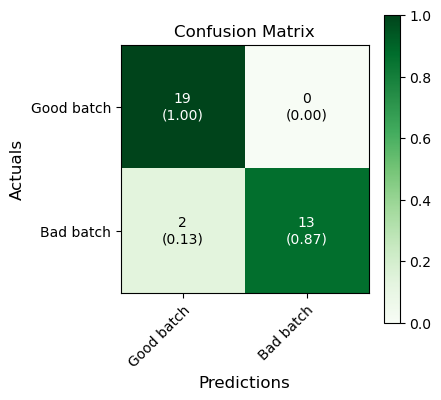

In [23]:
if __name__ == '__main__':
    main()